## Introduction

COVID-19, along with many respiratory viruses, is airborne [[1](https://www.science.org/doi/10.1126/science.abd9149)]. That means that they don't suddenly fall into the ground when emitted by an infectious person. They float in the air, and stay there for a long period of time, like smoke. The airborne nature of the virus has led to indoor air quality experts Richard Corsi & Jim Rosenthal to share their design of a simple Do-It-Yourself (DIY) air cleaner. The design involves taping a 20-inch-by-20-inch box fan to a box of air filters, which are called Corsi-Rosenthal (CR) boxes [[Clean Air Crew](https://cleanaircrew.org/boxfanfilterfaq/)]. A [UC Davis](https://energy.ucdavis.edu/wp-content/uploads/Case-Study_DIY-Portable-Air-Cleaners-083121.pdf) study shows that CR boxes are as effective in cleaning the air, while being a third of the cost of commercial air cleaners.

In 2020, some researchers studied the effectiveness of different cloth fabrics on filtration efficiency for masks [[[Konda](https://pubs.acs.org/doi/10.1021/acsnano.0c03252)], [[Hao](https://www.sciencedirect.com/science/article/pii/S1438463920305289?via%3Dihub)], [[Yang](https://docs.google.com/spreadsheets/d/17aJQn-zmhBWO9vlgfWQLAuRUNrxrUnE8Ftm2wUHlddI/edit#gid=0)]]. In Yang's research, they found that one layer of Rubbermaid microfiber has a filtration efficiency of about 46%, assuming an average inhalation rate of 60 liters per minute.

## Methods

### An equation for PM removal over time

Let $A$ represent the actual PM level, $t$ be the time in seconds, $d$ be the decaying factor (a fraction between 0 and 1), $n$ the filtration efficiency of the air cleaner, $c$ be the cubic feet per second output, and $v$ be the volume of the room (in cubic feet):

$$
\begin{equation}
\begin{aligned}
  A_{t+1} &= A_{t}d^{n \cdot c / v}
\end{aligned}
\end{equation}
$$


## Estimating the flow rate of the air cleaner

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

from linx.ds import BayesianNetwork as BN, \
    ConditionalProbabilityTable as CPT, \
    Query

from linx.data import ParquetData
from linx.infer import VariableElimination as VE

In [2]:
storage_path = Path(os.getcwd()) / "tmp"

In [3]:
storage_path.mkdir(exist_ok=True)

In [4]:
def miles_per_hour_to_feet_per_second(mph):
    """
    Miles per hour * 5280 feet / mile * 3600 sec / hour
    """
    return mph * 5280.0 / 3600

In [5]:
def circle_area(diameter):
    """
    Returns area of circle
    """
    radius = diameter / 2
    return np.pi * radius ** 2

In [6]:
miles_per_hour_to_feet_per_second(2)

2.933333333333333

### surface_area_of_layer_in_sq_ft

In [7]:
def surface_area_of_layer_in_sq_ft(
    layer,  
    num_layers,
    no_air_flow_middle_diam_inches, 
    with_air_flow_inches
):
    """
    Assuming 5 layers.
    
    1st layer is layer 0.
    
    Parameters:
        layer: integer
        
        num_layers: integer
            The number of circular layers.
            
        no_air_flow_middle_diam_inches: float
            This is the area of the circle that has no airflow, due to the design of 
            the box fan (i.e. some circle with a box fan logo). Measured in inches.
        
        with_air_flow_inches: float
            When added to no_air_flow_middle_diam_inches, we get a diameter, whose 
            circumference corresponds to the circle in which air is coming out of.
            
        
    Returns: float
        square-feet
    """
    num_inches_in_a_foot = 12
    
    if layer < 0 or layer > num_layers - 1:
        raise ValueError(f"Layer {layer} cannot be less than 0 or greater than 2.")
        
    engulfing_circle_area = circle_area(
        (
            no_air_flow_middle_diam_inches + (layer + 1) * with_air_flow_inches / num_layers
        ) / num_inches_in_a_foot
    )
    
    engulfed_circle_area = circle_area(
        (
            no_air_flow_middle_diam_inches + layer * with_air_flow_inches / num_layers
        ) / num_inches_in_a_foot
    )
    
    return (engulfing_circle_area - engulfed_circle_area)

In [8]:
surface_area_of_layer_in_sq_ft(
    layer=0,
    num_layers=3,
    no_air_flow_middle_diam_inches=5.5,
    with_air_flow_inches=8.0
)

0.1987736092549097

In [9]:
np.pi * ((8.0 * 1/3 + 5.5) / (12 * 2))**2 - (np.pi * (5.5 / (2 * 12)) ** 2)

0.1987736092549097

In [10]:
surface_area_of_layer_in_sq_ft(
    layer=1,
    num_layers=3,
    no_air_flow_middle_diam_inches=5.5,
    with_air_flow_inches=8.0
)

0.27634379823243543

In [11]:
np.pi * ((8.0 * 2/3 + 5.5) / (12 * 2))**2 - np.pi * ((8.0 * 1/3 + 5.5) / (12 * 2))**2

0.27634379823243543

In [12]:
surface_area_of_layer_in_sq_ft(
    layer=2,
    num_layers=3,
    no_air_flow_middle_diam_inches=5.5,
    with_air_flow_inches=8.0
)

0.35391398720996137

In [13]:
np.pi * ((8.0 + 5.5) / (12 * 2))**2 - np.pi * ((8.0 * 2/3 + 5.5) / (12 * 2))**2

0.35391398720996137

In [14]:
airflow_areas = [
    surface_area_of_layer_in_sq_ft(
        layer=layer,
        num_layers=3,
        no_air_flow_middle_diam_inches=5.5,
        with_air_flow_inches=8.0
    )
    for layer in range(3)
]

In [15]:
sum(airflow_areas)

0.8290313946973065

In [16]:
num_divisions = 12.0
surface_area_of_layer_in_sq_ft(
    layer=1,
    num_layers=3,
    no_air_flow_middle_diam_inches=5.5,
    with_air_flow_inches=8.0
) / num_divisions

0.02302864985270295

### anemometer_readings

In [17]:
anemometer_readings = pd.DataFrame([
    {
        'layer': 0,
        'group': 0,
        'reading': 0.4
    },
    {
        'layer': 0,
        'group': 0,
        'reading': 0.5
    },
    {
        'layer': 0,
        'group': 1,
        'reading': 1.2
    },
    {
        'layer': 0,
        'group': 1,
        'reading': 1.6
    },
    {
        'layer': 0,
        'group': 2,
        'reading': 1.1
    },
    {
        'layer': 0,
        'group': 2,
        'reading': 1.1
    },
    {
        'layer': 0,
        'group': 3,
        'reading': 1.3
    },
    {
        'layer': 0,
        'group': 3,
        'reading': 1.2
    },
    {
        'layer': 0,
        'group': 4,
        'reading': 0.3
    },
    {
        'layer': 0,
        'group': 4,
        'reading': 0.9
    },
    {
        'layer': 0,
        'group': 5,
        'reading': 0.3
    },
    {
        'layer': 0,
        'group': 5,
        'reading': 0.5
    },
    {
        'layer': 0,
        'group': 6,
        'reading': 0.3
    },
    {
        'layer': 0,
        'group': 6,
        'reading': 0.5
    },
    {
        'layer': 0,
        'group': 7,
        'reading': 0.5
    },
    {
        'layer': 0,
        'group': 7,
        'reading': 0.4
    },
    {
        'layer': 0,
        'group': 8,
        'reading': 1.3
    },
    {
        'layer': 0,
        'group': 8,
        'reading': 1.3
    },
    {
        'layer': 0,
        'group': 9,
        'reading': 1.5
    },
    {
        'layer': 0,
        'group': 9,
        'reading': 1.3
    },
    {
        'layer': 0,
        'group': 10,
        'reading': 1.2
    },
    {
        'layer': 0,
        'group': 10,
        'reading': 1.7
    },
    {
        'layer': 0,
        'group': 11,
        'reading': 1.6
    },
    {
        'layer': 0,
        'group': 11,
        'reading': 1.0
    },

    {
        'layer': 1,
        'group': 0,
        'reading': 2.8
    },
    {
        'layer': 1,
        'group': 0,
        'reading': 2.1
    },
    {
        'layer': 1,
        'group': 1,
        'reading': 2.7
    },
    {
        'layer': 1,
        'group': 1,
        'reading': 2.1
    },
    {
        'layer': 1,
        'group': 2,
        'reading': 2.0
    },
    {
        'layer': 1,
        'group': 2,
        'reading': 2.2
    },
    {
        'layer': 1,
        'group': 3,
        'reading': 3.0
    },
    {
        'layer': 1,
        'group': 3,
        'reading': 3.1
    },
    {
        'layer': 1,
        'group': 4,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 4,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 5,
        'reading': 2.5
    },
    {
        'layer': 1,
        'group': 5,
        'reading': 2.5
    },
    {
        'layer': 1,
        'group': 6,
        'reading': 1.6
    },
    {
        'layer': 1,
        'group': 6,
        'reading': 2.2
    },
    {
        'layer': 1,
        'group': 7,
        'reading': 2.5
    },
    {
        'layer': 1,
        'group': 7,
        'reading': 2.3
    },
    {
        'layer': 1,
        'group': 8,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 8,
        'reading': 2.5
    },
    {
        'layer': 1,
        'group': 9,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 9,
        'reading': 2.0
    },
    {
        'layer': 1,
        'group': 10,
        'reading': 2.0
    },
    {
        'layer': 1,
        'group': 10,
        'reading': 2.6
    },
    {
        'layer': 1,
        'group': 11,
        'reading': 2.4
    },
    {
        'layer': 1,
        'group': 11,
        'reading': 2.4
    },

    {
        'layer': 2,
        'group': 0,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 0,
        'reading': 1.0
    },
    {
        'layer': 2,
        'group': 1,
        'reading': 1.1
    },
    {
        'layer': 2,
        'group': 1,
        'reading': 1.0
    },
    {
        'layer': 2,
        'group': 2,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 2,
        'reading': 0.6
    },
    {
        'layer': 2,
        'group': 3,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 3,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 4,
        'reading': 1.7
    },
    {
        'layer': 2,
        'group': 4,
        'reading': 1.2
    },
    {
        'layer': 2,
        'group': 5,
        'reading': 0.6
    },
    {
        'layer': 2,
        'group': 5,
        'reading': 0.7
    },
    {
        'layer': 2,
        'group': 6,
        'reading': 0.4
    },
    {
        'layer': 2,
        'group': 6,
        'reading': 0.4
    },
    {
        'layer': 2,
        'group': 7,
        'reading': 1.6
    },
    {
        'layer': 2,
        'group': 7,
        'reading': 1.0
    },
    {
        'layer': 2,
        'group': 8,
        'reading': 1.1
    },
    {
        'layer': 2,
        'group': 8,
        'reading': 1.1
    },
    {
        'layer': 2,
        'group': 9,
        'reading': 1.0
    },
    {
        'layer': 2,
        'group': 9,
        'reading': 0.9
    },
    {
        'layer': 2,
        'group': 10,
        'reading': 0.5
    },
    {
        'layer': 2,
        'group': 10,
        'reading': 1.1
    },
    {
        'layer': 2,
        'group': 11,
        'reading': 0.9
    },
    {
        'layer': 2,
        'group': 11,
        'reading': 1.0
    }
])


### create_anemometer_cpt_df

In [18]:
def create_anemometer_cpt_df(size):
    """
    Generates a dataframe that represents the conditional probility table for 
    P(anemometer reading value | actual wind speed).
    
    Assumes that the measured feet per second of the anemometer is produced by 
    Gaussian centered at the actual feet per second value, with a standard 
    deviation of 0.1.
    
    Parameters
    """
    dfs = []
    minimum = 0
    maximum = 15
    for actual_cfs in np.arange(minimum, maximum, 0.1):
        cubic_feet_per_second = np.random.normal(actual_cfs, 0.1, size=size)
        
        df = pd.DataFrame({
            'actual_mps': round(actual_cfs, 2),
            'measured_mps': [round(cfs, 1) for cfs in cubic_feet_per_second],
            'value': 0
        })
            
        dfs.append(df)
    
    dfs = pd.concat(dfs)
    
    rates = (
        dfs.groupby(['actual_mps', 'measured_mps']).count()[['value']] \
        / dfs.groupby(['actual_mps']).count()[['value']]
    ).reset_index()
            
    valid_values = rates[(rates['measured_mps'] >= 0)]
    
    normalized = valid_values.set_index(['actual_mps', 'measured_mps'])[['value']] \
        / valid_values.groupby(['actual_mps']).sum()[['value']]
    
    return normalized.reset_index()

In [19]:
anemometer_reading_df = create_anemometer_cpt_df(10000)
anemometer_reading_df

,actual_mps,measured_mps,value
0,0.0,-0.0,0.560558
1,0.0,0.1,0.344467
2,0.0,0.2,0.088295
3,0.0,0.3,0.006099
4,0.0,0.4,0.000581
...,...,...,...
1307,14.9,14.8,0.236700
1308,14.9,14.9,0.388300
1309,14.9,15.0,0.244300
1310,14.9,15.1,0.063500


### generate_flat_priors

In [20]:
def generate_flat_priors(start, end, step, name, round_to=1):
    """
    Parameters:
        start: float
            The lower bound
        end: float
            The upper bound
        step: float
            The increment that will be taken to go from start to end
        round_to: integer
            We round the value so that we can compare floats more easily.
    """
    array = np.arange(start, end, step)
    
    proba = 1.0 / len(array)
    
    return pd.DataFrame(
        [{'value': proba, name: round(i, round_to)} for i in array]
    )


In [21]:
priors = generate_flat_priors(0,5,0.1,'actual_mps')

### generate_cpts_for_anemometer_readings

In [22]:
def generate_cpts_for_anemometer_readings(
    number_of_readings, 
    anemometer_reading_df,
    given,
    outcome
):
    """
    Generate conditional probability tables of anemometer readings.
    
    Parameters:
        number_of_readings: integer
        anemometer_reading_df: pd.DataFrame
        givens: list[str]
            The list of variables that are in the conditional.
        
    Returns: list[CPT]
    """
    cpts = []

    for i in range(number_of_readings):
        cpt = CPT(
            ParquetData(
                anemometer_reading_df.rename(
                    columns={
                        'measured_mps': f'{outcome}_{i}',
                        'actual_mps': f'{given}'
                    }
                ),
                storage_folder=storage_path
            ),
            outcomes=[f'{outcome}_{i}'],
            givens=[given]
        )
        cpts.append(cpt)
        
    return cpts

In [23]:
cpts = generate_cpts_for_anemometer_readings(
    number_of_readings=2,
    anemometer_reading_df=anemometer_reading_df,
    given='actual_mps',
    outcome='measured_mps'
)

In [24]:
priors

,value,actual_mps
0,0.02,0.0
1,0.02,0.1
2,0.02,0.2
3,0.02,0.3
4,0.02,0.4
5,0.02,0.5
6,0.02,0.6
7,0.02,0.7
8,0.02,0.8
9,0.02,0.9


In [25]:
bn = BN(
    cpts=cpts,
    priors=[
        CPT(
            ParquetData(
                priors,
                storage_folder=storage_path
            ),
            outcomes=['actual_mps']
        )
    ],
    graphviz_dag=graphviz.Digraph()
)

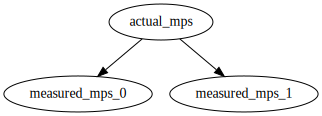

In [26]:
bn.graphviz_dag

In [27]:
factor = VE(
    network=bn,
    query=Query(
        outcomes=['actual_mps'],
        givens=[
            {
                'measured_mps_0': 1.0
            },
            {
                'measured_mps_1': 0.9
            },
        ]
    )
).compute()

numerator: 0it [00:00, ?it/s]
denominator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.05it/s]


In [28]:
factor.get_df()

,measured_mps_1,measured_mps_0,actual_mps,value
0,0.9,1.0,0.6,0.000005
1,0.9,1.0,0.7,0.002127
2,0.9,1.0,0.8,0.071956
3,0.9,1.0,0.9,0.440202
4,0.9,1.0,1.0,0.417247
5,0.9,1.0,1.1,0.067161
6,0.9,1.0,1.2,0.001291
7,0.9,1.0,1.3,0.000011


<AxesSubplot:xlabel='actual_mps'>

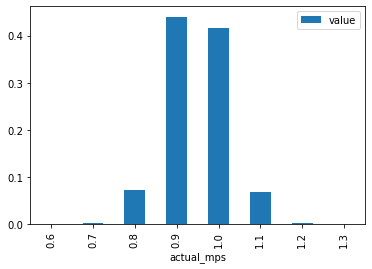

In [29]:
factor.get_df()[['actual_mps', 'value']].set_index('actual_mps').plot.bar()

### sample_total_air_delivery_rate

In [30]:
def sample_total_air_delivery_rate(
    anemometer_readings,
    num_sections_per_layer = 12.0,
    num_feet_in_meters = 3.28084,
    num_layers = 3,
    no_air_flow_middle_diam_inches = 5.5,
    with_air_flow_inches = 8.0,
    sample_size = 10000
):
    """
    Sample total air delivery rate.
    """
    total = np.zeros(sample_size)

    for layer in range(num_layers):

        sq_ft_section = surface_area_of_layer_in_sq_ft(
            layer=layer,
            num_layers=num_layers,
            no_air_flow_middle_diam_inches=no_air_flow_middle_diam_inches,
            with_air_flow_inches=with_air_flow_inches
        ) / num_sections_per_layer

        for group in range(int(num_sections_per_layer)):
            wind_speed_readings_for_layer_group = anemometer_readings[
                (anemometer_readings['layer'] == layer) \
                & (anemometer_readings['group'] == group)
            ]

            reading_0 = wind_speed_readings_for_layer_group.iloc[0]['reading']
            reading_1 = wind_speed_readings_for_layer_group.iloc[1]['reading']
            query = Query(
                outcomes=['actual_mps'],
                givens=[
                    {
                        'measured_mps_0': reading_0
                    },
                    {
                        'measured_mps_1': reading_1
                    },
                ]
            )

            factor = VE(
                network=bn,
                query=query
            ).compute()

            result = factor.get_df()
            actual_windspeed_in_meters_per_second = \
                np.random.choice(
                    result['actual_mps'], 
                    p=result['value'], 
                    size=sample_size
                )

            actual_windspeed_in_feet_per_second = \
                actual_windspeed_in_meters_per_second * num_feet_in_meters

            mean_windspeed = actual_windspeed_in_feet_per_second.mean()
            total = total + actual_windspeed_in_feet_per_second * sq_ft_section
            
    return pd.Series(total)

numerator: 0it [00:00, ?it/s]
denominator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.72it/s]
numerator: 0it [00:00, ?it/s]
denominator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]
numerator: 0it [00:00, ?it/s]
denominator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]
numerator: 0it [00:00, ?it/s]
denominator: 100%|███████████████████████████████████████████

<AxesSubplot:title={'center':'Total Air Delivery Rate of CR Microfiber'}, xlabel='Cubic Feet per Second', ylabel='Density'>

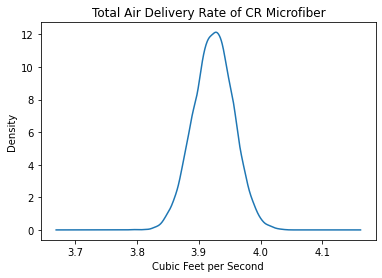

In [31]:
adr_microfiber = sample_total_air_delivery_rate(
    anemometer_readings=anemometer_readings
)
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Cubic Feet per Second')
pd.Series(adr_microfiber).plot.kde(title='Total Air Delivery Rate of CR Microfiber', ax=ax)

In [32]:
anemometer_readings['reading'].mean()

1.4416666666666667

Lit 3 matches, waited for a few minutes to ensure that the particle counter got a massive jump in readings (i.e. n0_3 jumped to 1800).

- Left at 8:01
- Turned on fan at 9:01
- Switched to Coway at 10:03
- Stopped data collection at 10:33

## Particle Counter Data

In [33]:
particle_counter_data = pd.read_json("pms_7003_1.json", orient='records', lines=True).set_index('datetime')

In [34]:
particle_counter_data

,pm1_0cf1,pm2_5cf1,pm10cf1,pm1_0,pm2_5,pm10,n0_3,n0_5,n1_0,n2_5,n5_0,n10,sensor_num
datetime,,,,,,,,,,,,,
2021-12-18 19:53:27.899489,0,0,0,0,0,0,3,1,1,1,0,0,0
2021-12-18 19:53:28.817320,0,0,0,0,0,0,3,1,1,1,0,0,0
2021-12-18 19:53:29.655135,0,0,0,0,0,0,3,1,1,1,0,0,0
2021-12-18 19:53:30.573125,0,0,0,0,0,0,6,2,1,1,0,0,0
2021-12-18 19:53:31.410849,0,0,0,0,0,0,6,2,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-18 22:33:46.151964,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-18 22:33:47.005828,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-18 22:33:47.923702,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='datetime'>

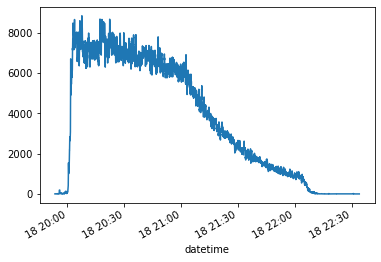

In [35]:
particle_counter_data['n0_3'].plot()

<AxesSubplot:xlabel='datetime'>

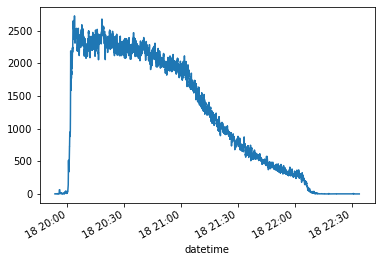

In [36]:
particle_counter_data['n0_5'].plot()

<AxesSubplot:xlabel='datetime'>

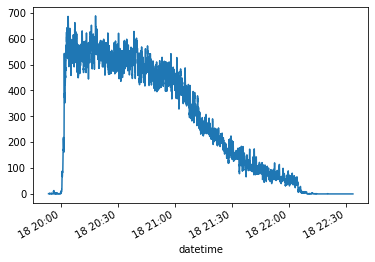

In [37]:
particle_counter_data['n1_0'].plot()

<AxesSubplot:xlabel='datetime'>

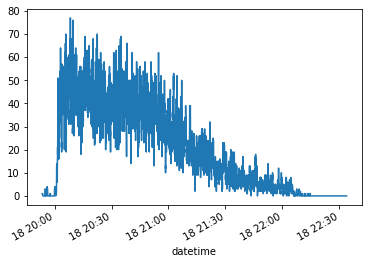

In [38]:
particle_counter_data['n2_5'].plot()

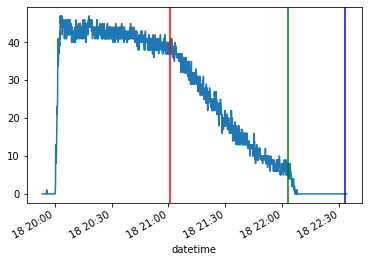

In [39]:
fig, ax = plt.subplots()
particle_counter_data['pm1_0'].plot(ax=ax)
ax.axvline("2021-12-18 21:01", color='r')
ax.axvline("2021-12-18 22:03", color='g')
ax.axvline("2021-12-18 22:33", color='b')

In [40]:
particle_reset = particle_counter_data.reset_index()

In [41]:
def time_at(time_str, df):
    time_str_plus_one_second = pd.to_datetime(time_str) + pd.Timedelta('1 second')
    
    return (df['datetime'] >= time_str) & \
        (df['datetime'] < time_str_plus_one_second)
    

In [42]:
pd.to_datetime('2021-12-18 21:01:00') + pd.Timedelta('1 second')

Timestamp('2021-12-18 21:01:01')

In [43]:
particle_reset[
    time_at('2021-12-18 21:04:00', df=particle_reset)
]

,datetime,pm1_0cf1,pm2_5cf1,pm10cf1,pm1_0,pm2_5,pm10,n0_3,n0_5,n1_0,n2_5,n5_0,n10,sensor_num
4737,2021-12-18 21:04:00.179341,47,75,79,37,59,71,5457,1804,426,31,5,2,0


In [44]:
particle_reset[particle_reset['datetime'] > '2021-12-18 21:01']

,datetime,pm1_0cf1,pm2_5cf1,pm10cf1,pm1_0,pm2_5,pm10,n0_3,n0_5,n1_0,n2_5,n5_0,n10,sensor_num
4537,2021-12-18 21:01:00.717187,52,84,87,40,63,76,6219,1969,478,40,3,1,0
4538,2021-12-18 21:01:01.619060,52,86,90,40,63,78,6234,1969,516,46,4,2,0
4539,2021-12-18 21:01:02.537044,52,84,90,40,63,78,6195,1957,527,42,4,2,0
4540,2021-12-18 21:01:03.438805,53,86,88,40,63,76,6354,1984,516,38,3,2,0
4541,2021-12-18 21:01:04.340676,55,86,88,41,63,76,6426,2009,514,34,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,2021-12-18 22:33:46.151964,0,0,0,0,0,0,0,0,0,0,0,0,0
10796,2021-12-18 22:33:47.005828,0,0,0,0,0,0,0,0,0,0,0,0,0
10797,2021-12-18 22:33:47.923702,0,0,0,0,0,0,0,0,0,0,0,0,0
10798,2021-12-18 22:33:48.777555,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
particle_counter_data['pm1_0']

datetime
2021-12-18 19:53:27.899489    0
2021-12-18 19:53:28.817320    0
2021-12-18 19:53:29.655135    0
2021-12-18 19:53:30.573125    0
2021-12-18 19:53:31.410849    0
                             ..
2021-12-18 22:33:46.151964    0
2021-12-18 22:33:47.005828    0
2021-12-18 22:33:47.923702    0
2021-12-18 22:33:48.777555    0
2021-12-18 22:33:49.695432    0
Name: pm1_0, Length: 10800, dtype: int64

In [46]:
720/3.8

189.47368421052633

In [47]:
1.0 - np.exp((720.0 / (3.8 * 3600)) * np.log(4)) 

-0.07569058622018243

In [48]:
 ((720.0 / 180) * np.log(1.0/9)) / np.log(0.0003)

1.083480390254976

In [49]:
1 - np.exp(1215.0 / (233.0 * 30.0) * np.log(1-0.996))

0.6170071333491278

In [50]:
(720.0 / (3600.0 * 3.8)) * np.log(1.0/4) / np.log(1-0.617)

0.07602513137100067

In [51]:
1.0 / 2.718

0.36791758646063283

In [52]:
0.9**3600

1.8751412236067268e-165

In [53]:
np.exp(sum([np.log(0.9) for i in range(3600)]))

1.8751412236327937e-165

### pm_actual

In [54]:
def pm_actual(
    last_value,
    filtration_eff,
    decay,
    air_delivery_rate,
    room_volume,
):
    power = filtration_eff * air_delivery_rate / room_volume 
    return last_value * (decay) ** power

### apply_recursive_pm

In [55]:
def apply_recursive_pm(
    start_pm=100,
    filtration_eff=0.07,
    decay=0.383,
    air_delivery_rate=3.7,
    room_volume=720
):

    collection = [start_pm]

    for i in range(3599):

        new_value = pm_actual(
            last_value=collection[i],
            filtration_eff=filtration_eff,
            decay=decay,
            air_delivery_rate=air_delivery_rate,
            room_volume=room_volume,
        )

        collection.append(new_value)
    
    return pd.Series(collection)

In [56]:
collection = apply_recursive_pm(
    start_pm=40,
    filtration_eff=0.08,
    decay=0.383,
    air_delivery_rate=3.7,
    room_volume=720
)

In [57]:
pm_readings = particle_counter_data.reset_index()


In [58]:
microfiber = pm_readings[
    (pm_readings['datetime'] > '2021-12-18 21:01') & 
    (pm_readings['datetime'] <= '2021-12-18 22:01')
]

In [59]:
microfiber['datetime'].dt.hour

4537    21
4538    21
4539    21
4540    21
4541    21
        ..
8567    22
8568    22
8569    22
8570    22
8571    22
Name: datetime, Length: 4035, dtype: int64

### Produce simulated data using priors (prior predictive distribution)

In [60]:
microfiber.loc[:, 'rank'] = microfiber.groupby(
    [
        microfiber['datetime'].dt.hour,
        microfiber['datetime'].dt.minute,
        microfiber['datetime'].dt.second
    ]
)['datetime'].transform('rank').copy()

/Users/eugaddan/miniconda3/envs/linx_dev_env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [61]:
only_one_reading = microfiber[microfiber['rank'] == 1].reset_index()

<AxesSubplot:>

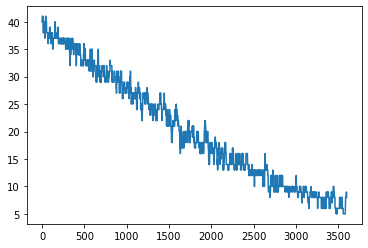

In [62]:
only_one_reading['pm1_0'].plot()

<AxesSubplot:>

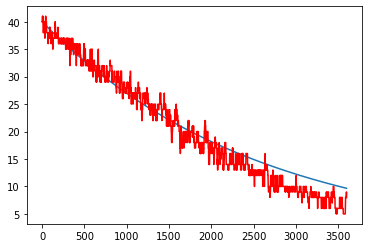

In [63]:
fig, ax = plt.subplots()
collection.plot(ax=ax)
only_one_reading['pm1_0'].plot(ax=ax, color='r')



<AxesSubplot:xlabel='datetime'>

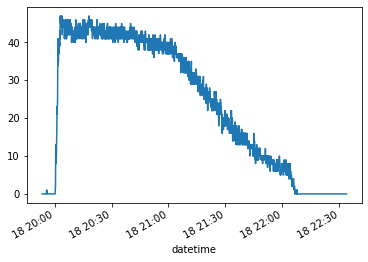

In [64]:
particle_counter_data['pm1_0'].plot()

<AxesSubplot:xlabel='datetime'>

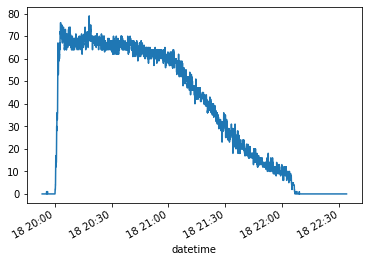

In [65]:
particle_counter_data['pm2_5'].plot()

<AxesSubplot:xlabel='datetime'>

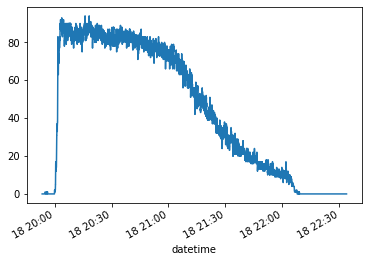

In [66]:
particle_counter_data['pm10'].plot()

<AxesSubplot:xlabel='datetime'>

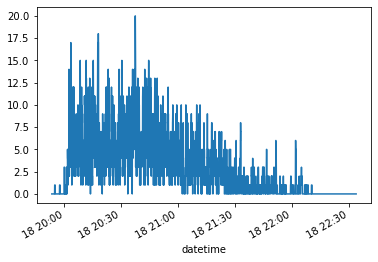

In [67]:
particle_counter_data['n5_0'].plot()

<AxesSubplot:xlabel='datetime'>

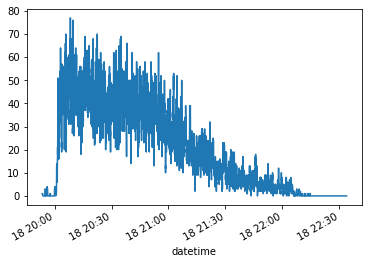

In [68]:
particle_counter_data['n2_5'].plot()

In [69]:
total_area = np.pi * ((5.5+8)/(2* 12))**2
no_airflow_area = np.pi * (5.5/(12 * 2))**2

avg_mps = anemometer_readings['reading'].mean()
avg_fps = avg_mps * 3.28
airflow_estimate = (total_area - no_airflow_area) * avg_fps

In [70]:
se = anemometer_readings['reading'].std() / np.sqrt(anemometer_readings.shape[0])
(airflow_estimate - se, airflow_estimate + se)

(3.8297710237678957, 4.010655219682763)

In [71]:
total_area - no_airflow_area

0.8290313946973065

## Calculate Air Delivery Rate of Coway AP-1512HH

In [72]:
def cubic_feet_per_second(fs_of_layers, surface_areas_of_layers):
    """
    Parameters:
        fs_of_layers: np.array[float]
            Rate of airflow of each layer (Feet per second)
        surface_areas_of_layers: np.array[float]
            Surface area of each layer (Square feet)
            
    Returns: float
    """
    
    return (fs_of_layers * surface_areas_of_layers).sum()

In [73]:
round(1.2345,1)

1.2

In [74]:
# def create_airflow_rate_table():
#     collection = []
          
#     surface_areas_of_layers = [
#         surface_area_of_layer_in_sq_ft(i) for i in range(5)
#     ]
    
    
#     for layer_0_fs in np.arange(0, 15, 0.1):
#         layer_0_fs = round(layer_0_fs, 2)
        
#         for layer_1_fs in np.arange(0, 15, 0.1):
#             layer_1_fs = round(layer_1_fs, 2)
            
#             for layer_2_fs in np.arange(0, 15, 0.1):
#                 layer_2_fs = round(layer_2_fs, 2)
                
#                 for layer_3_fs in np.arange(0, 15, 0.1):
#                     layer_3_fs = round(layer_3_fs, 2)
                    
#                     for layer_4_fs in np.arange(0, 15, 0.1):
#                         layer_4_fs = round(layer_4_fs, 2)
                        
#                         fs_of_layers = np.array([
#                             layer_0_fs,
#                             layer_1_fs,
#                             layer_2_fs,
#                             layer_3_fs,
#                             layer_4_fs
#                         ])
                        
#                         cfs = cubic_feet_per_second(
#                             fs_of_layers, 
#                             surface_areas_of_layers
#                         )

#                         for layer, fs in enumerate(fs_of_layers):
#                             dictionary['flayer {layer} feet per second'] = fs
                            
#                         dictionary['cubic feet per second'] = round(cfs, 1)
#                         dictionary['value'] = 1
                        
#                         collection.append(dictionary)
                        
#                         for i in np.arange(0, 15, 0.1):
                        
                        

#     cfs = cubic_feet_per_second(
#         fs_of_layers, 
#         surface_areas_of_layers
#     )
    
#     dictionary['airflow'] = cfs

In [75]:
def least_significant_digit_power(num_string):
    if '.' in num_string:
        # There's a decimal point. Figure out how many digits are to the right
        # of the decimal point and negate that.
        return len(num_string.partition('.')[2])
    else:
        # No decimal point. Count trailing zeros.
        return len(num_string) - len(num_string.rstrip('0'))

In [76]:
least_significant_digit_power("0.123456")

6

### accuracy

In [77]:
def accuracy(mps):
    """
    Parameters:
        Reading in meters per second (m/s)
    """
    
    # m / s * 3.28084 ft / m
    #mps = reading * 3.28084
    val_1 = 0.03 * mps
    val_2 = mps - int(mps)
    # 20 ft/min * 1 min / 60 sec = 0.33 ft / sec
    val_3 = 0.33
    
    return max(val_1, val_2, val_3)
    
    

<AxesSubplot:>

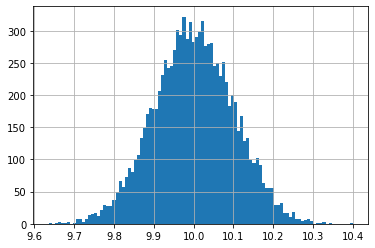

In [78]:
pd.Series(np.random.normal(10, 0.1, size=10000)).hist(bins=100)

### meters_to_feet

In [79]:
def meters_to_feet(meters):
    return meters * 3.280 # feet per meter

### inches_to_feet

In [80]:
def inches_to_feet(inches):
    return inches / 12.0

### coway_mps

In [81]:
coway_mps = pd.DataFrame(
    [
        {'x': 0, 'y': 0, "measured_mps": 10.5},
        {'x': 0, 'y': 1, "measured_mps": 10.4},
        {'x': 0, 'y': 2, "measured_mps": 8.4},
        {'x': 1, 'y': 0, "measured_mps": 9.8},
        {'x': 1, 'y': 1, "measured_mps": 11.8},
        {'x': 1, 'y': 2, "measured_mps": 10.1},
        {'x': 2, 'y': 0, "measured_mps": 8.6},
        {'x': 2, 'y': 1, "measured_mps": 9.8},
        {'x': 2, 'y': 2, "measured_mps": 8.6},
        {'x': 3, 'y': 0, "measured_mps": 8.6},
        {'x': 3, 'y': 1, "measured_mps": 10.1},
        {'x': 3, 'y': 2, "measured_mps": 8.6},
    ]
)


### compute_cfps_rectangular_air_cleaner

In [82]:


def compute_cfps_rectangular_air_cleaner(
    num_sub_sections,
    mps,
    width_in=4.75,
    height_in=3.75,
    num_sims=10000
):
    """
    Parameters:
        num_sub_sections: integer
            Number of sub-sections in the rectangular area.
        mps: float
            Flow rate in meters per second.
        total_area: float
            Total area in square inches.
        num_sims: integer
            Number of simulations
    """
    total = np.zeros(num_sims)
    sub_area = inches_to_feet(width_in) * inches_to_feet(height_in) / num_sub_sections

    for i, row in mps.iterrows():
        total += np.random.normal(
            meters_to_feet(row['measured_mps']),
            0.1,
            size=num_sims
        ) * sub_area

    return pd.Series(total)


In [83]:
coway_cfps = compute_cfps_rectangular_air_cleaner(
    num_sub_sections = coway_mps.shape[0],
    mps=coway_mps,
    width_in=4.75,
    height_in=3.75,
)

Text(0.5, 0, 'Cubic Feet per Second')

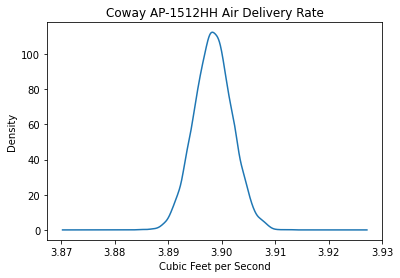

In [84]:
fig, ax = plt.subplots()
coway_cfps.plot.kde(
    ax=ax
)
ax.set_title("Coway AP-1512HH Air Delivery Rate")
ax.set_xlabel("Cubic Feet per Second")

This aligns with the manufacturer's claim that this is good for 360 sq. ft (to get 4 ACH):

Text(0.5, 0, 'Cubic Feet per Hour')

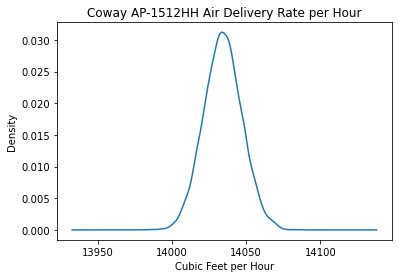

In [85]:
fig, ax = plt.subplots()
(coway_cfps * 3600).plot.kde(title='Coway AP-1512HH Air Delivery Rate per Hour', ax=ax)
ax.set_xlabel("Cubic Feet per Hour")

In [86]:
cfps = pd.DataFrame({'cfps': coway_cfps.round(3)})

In [87]:
cfps['value'] = 0

In [88]:
def normalize(df, x='cfps'):
    return df.groupby(x).count() / df.groupby(x).count().sum()

In [89]:
coway_cfps_normalized = normalize(cfps.rename(columns={'cfps': 'AP-1512HH cfps'}), x='AP-1512HH cfps')
coway_cfps_normalized

,value
AP-1512HH cfps,
3.884,0.0002
3.885,0.0002
3.886,0.0001
3.887,0.0006
3.888,0.0011
3.889,0.0033
3.890,0.0058
3.891,0.0130
3.892,0.0224


In [90]:
CPT(
    ParquetData(
        coway_cfps_normalized,
        storage_folder=storage_path
    ), 
    outcomes=['AP-1512HH cfps']
)

ConditionalProbabilityTable(
	givens: [],
	outcomes: ['AP-1512HH cfps']
	df:
	
                 value
AP-1512HH cfps        
3.884           0.0002
3.885           0.0002
3.886           0.0001
3.887           0.0006
3.888           0.0011
3.889           0.0033
3.890           0.0058
3.891           0.0130
3.892           0.0224
3.893           0.0373
3.894           0.0499
3.895           0.0704
3.896           0.0881
3.897           0.1038
3.898           0.1127
3.899           0.1108
3.900           0.1028
3.901           0.0818
3.902           0.0680
3.903           0.0480
3.904           0.0334
3.905           0.0210
3.906           0.0116
3.907           0.0071
3.908           0.0043
3.909           0.0017
3.910           0.0002
3.911           0.0001
3.912           0.0001
3.913           0.0002)

TODO:

- generate conditional probability tables for actual -> measurement.
- Loop through from 0 to 100.
    - generate data
    - normalize
- handle case when generated data is below 0. Renormalize.

In [91]:
def generate_df_for_actual_pm_to_measured_pm(
    actual_upper_limit=100, 
    std=4,
    num_sims=10000
):
    """
    Parameters:
        actual_upper_limit: integer
            The highest number of particles to generate.
            
        std: numeric
            Standard deviation to use for generating measured_pm
            
        num_sims: integer
            The number of simulations.
    """
    concatables = []
    
    for u in range(actual_upper_limit):
        
        df = pd.DataFrame({
            'measured_pm': np.random.normal(u, std, size=num_sims)
        })
        df['actual_pm'] = u
        
        concatables.append(df)
        
    concat_df = pd.concat(concatables)
    
    concat_df['measured_pm'] = concat_df['measured_pm'].round()
    
    no_neg_df = concat_df[concat_df['measured_pm'] >= 0]
    no_neg_df['value'] = 0
    
    return no_neg_df.groupby(['actual_pm', 'measured_pm'])[['value']].count() / \
        no_neg_df.groupby(['actual_pm'])[['value']].count()

In [92]:
measurement_df = generate_df_for_actual_pm_to_measured_pm()

/var/folders/c3/b8f8shqn6sq34qlk8wt9rcqh0000gn/T/ipykernel_73159/951850254.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_neg_df['value'] = 0


In [93]:
def pm_actual_simplified(
    last_value,
    clean_air_delivery_rate,
    decay,
    room_volume,
):
    return clean_air_delivery_rate / room_volume 
    return last_value * (decay) ** power

In [94]:
def generate_cadr_df(
    adr_cfps_range=np.arange(0,12,0.1),
    filtration_eff_range=np.arange(0,1,0.01)
):
    collection = []
    
    df_1 = pd.DataFrame(
        {
            'adr_cfps': adr_cfps_range,
            'join_col': 1
        }
    )
    
    df_2 = pd.DataFrame(
        {
            'filtration_eff': filtration_eff_range,
            'join_col': 1
        }
    )
    
    merged = df_1.merge(df_2, on='join_col')
    
    merged['cadr_cfps'] = (merged['adr_cfps'] * merged['filtration_eff']).round(1)
    merged['value'] = 1.0
    
    return merged.drop(columns=['join_col'])

In [95]:
cadr_df = generate_cadr_df()

In [96]:
cadr_df['adr_cfps'] = cadr_df['adr_cfps'].round(1)
cadr_df['filtration_eff'] = cadr_df['filtration_eff'].round(2)

In [97]:
def generate_power_df(
    cadr_cfps_range=np.arange(0,12,0.1),
    room_volume=list(range(690, 726))
):
    collection = []
    
    df_1 = pd.DataFrame(
        {
            'cadr_cfps': cadr_cfps_range,
            'join_col': 1
        }
    )
    
    df_2 = pd.DataFrame(
        {
            'room_vol': room_volume,
            'join_col': 1
        }
    )
    
    merged = df_1.merge(df_2, on='join_col')
    
    merged['power'] = (merged['cadr_cfps'] / merged['room_vol']).round(3)
    merged['value'] = 1.0
    
    return merged.drop(columns=['join_col'])

In [98]:
power_df = generate_power_df()
power_df

,cadr_cfps,room_vol,power,value
0,0.0,690,0.000,1.0
1,0.0,691,0.000,1.0
2,0.0,692,0.000,1.0
3,0.0,693,0.000,1.0
4,0.0,694,0.000,1.0
...,...,...,...,...
4315,11.9,721,0.017,1.0
4316,11.9,722,0.016,1.0
4317,11.9,723,0.016,1.0
4318,11.9,724,0.016,1.0


In [99]:
def pm_actual_simplified(
    last_value,
    clean_air_delivery_rate,
    decay,
    room_volume,
):
    power = clean_air_delivery_rate / room_volume 
    return last_value * (decay) ** power

<AxesSubplot:ylabel='Frequency'>

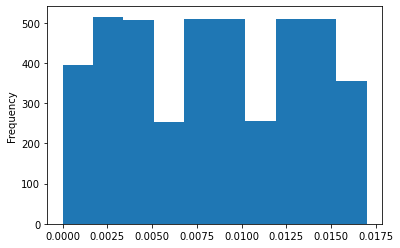

In [100]:
power_df['power'].plot.hist()

In [101]:
0.01 ** 0.001

0.995405417351527

In [102]:
def join_two_df(
    column_1,
    column_1_values,
    column_2,
    column_2_values,
    column_outcome,
    func
):
    
    df_1 = pd.DataFrame(
        {
            column_1: column_1_values,
            'join_col': 1
        }
    )
    
    df_2 = pd.DataFrame(
        {
            column_2: column_2_values,
            'join_col': 1
        }
    )
    
    merged = df_1.merge(df_2, on='join_col')
    
    merged[column_outcome] = func(merged)
    merged['value'] = 1.0
    
    return merged.drop(columns=['join_col'])

In [103]:
decay_power_multiplier_df = join_two_df(
    column_1='decay',
    column_1_values=np.arange(0, 1, 0.01),
    column_2='power',
    column_2_values=np.arange(0, 0.02, 0.001),
    column_outcome='decay_power_multiplier',
    func=lambda df: (df['decay'] ** df['power']).round(3)
)

decay_power_multiplier_df['decay'] = decay_power_multiplier_df['decay'].round(2)
decay_power_multiplier_df['power'] = decay_power_multiplier_df['power'].round(3)

In [104]:
decay_power_multiplier_df[decay_power_multiplier_df['decay'] == 0.50]

,decay,power,decay_power_multiplier,value
1000,0.5,0.000,1.000,1.0
1001,0.5,0.001,0.999,1.0
1002,0.5,0.002,0.999,1.0
1003,0.5,0.003,0.998,1.0
1004,0.5,0.004,0.997,1.0
1005,0.5,0.005,0.997,1.0
1006,0.5,0.006,0.996,1.0
1007,0.5,0.007,0.995,1.0
1008,0.5,0.008,0.994,1.0
1009,0.5,0.009,0.994,1.0


In [105]:
actual_pm_df = join_two_df(
    column_1='decay_power_multiplier',
    column_1_values=np.arange(0, 1, 0.001),
    column_2='actual_pm_t-1',
    column_2_values=list(range(0, 101)),
    column_outcome='actual_pm_t',
    func=lambda df: (df['actual_pm_t-1'] * df['decay_power_multiplier']).round().astype('int16')
)

In [106]:
actual_pm_df

,decay_power_multiplier,actual_pm_t-1,actual_pm_t,value
0,0.000,0,0,1.0
1,0.000,1,0,1.0
2,0.000,2,0,1.0
3,0.000,3,0,1.0
4,0.000,4,0,1.0
...,...,...,...,...
100995,0.999,96,96,1.0
100996,0.999,97,97,1.0
100997,0.999,98,98,1.0
100998,0.999,99,99,1.0


In [107]:
actual_pm_df['decay_power_multiplier'] = actual_pm_df['decay_power_multiplier'].round(3)

In [108]:
def generate_flat_prior(prior_range, prior_name):
    df = pd.DataFrame(
        {
            prior_name: prior_range
        }
    )
    
    df['value'] = 1
    
    df['value'] = df['value'] / df['value'].sum()
    
    return df

In [109]:
CPT(
    ParquetData(
        generate_flat_prior(
            range(0,100), 
            prior_name='actual_pm t=0, CR=microfiber'
        ),
        storage_folder=storage_path
    ),
    outcomes=['actual_pm t=0, CR=microfiber']
)

ConditionalProbabilityTable(
	givens: [],
	outcomes: ['actual_pm t=0, CR=microfiber']
	df:
	
    actual_pm t=0, CR=microfiber  value
0                              0   0.01
1                              1   0.01
2                              2   0.01
3                              3   0.01
4                              4   0.01
..                           ...    ...
95                            95   0.01
96                            96   0.01
97                            97   0.01
98                            98   0.01
99                            99   0.01

[100 rows x 2 columns])

In [110]:
actual_pm_df

,decay_power_multiplier,actual_pm_t-1,actual_pm_t,value
0,0.000,0,0,1.0
1,0.000,1,0,1.0
2,0.000,2,0,1.0
3,0.000,3,0,1.0
4,0.000,4,0,1.0
...,...,...,...,...
100995,0.999,96,96,1.0
100996,0.999,97,97,1.0
100997,0.999,98,98,1.0
100998,0.999,99,99,1.0


In [111]:
decay_power_multiplier_df

,decay,power,decay_power_multiplier,value
0,0.00,0.000,1.0,1.0
1,0.00,0.001,0.0,1.0
2,0.00,0.002,0.0,1.0
3,0.00,0.003,0.0,1.0
4,0.00,0.004,0.0,1.0
...,...,...,...,...
1995,0.99,0.015,1.0,1.0
1996,0.99,0.016,1.0,1.0
1997,0.99,0.017,1.0,1.0
1998,0.99,0.018,1.0,1.0


In [112]:
decay_df = generate_flat_prior(
    np.arange(0,1, 0.01), 
    prior_name='decay'
)

decay_df['decay'] = decay_df['decay'].round(2)

In [113]:
power_df

,cadr_cfps,room_vol,power,value
0,0.0,690,0.000,1.0
1,0.0,691,0.000,1.0
2,0.0,692,0.000,1.0
3,0.0,693,0.000,1.0
4,0.0,694,0.000,1.0
...,...,...,...,...
4315,11.9,721,0.017,1.0
4316,11.9,722,0.016,1.0
4317,11.9,723,0.016,1.0
4318,11.9,724,0.016,1.0


In [114]:
cadr_df

,adr_cfps,filtration_eff,cadr_cfps,value
0,0.0,0.00,0.0,1.0
1,0.0,0.01,0.0,1.0
2,0.0,0.02,0.0,1.0
3,0.0,0.03,0.0,1.0
4,0.0,0.04,0.0,1.0
...,...,...,...,...
11995,11.9,0.95,11.3,1.0
11996,11.9,0.96,11.4,1.0
11997,11.9,0.97,11.5,1.0
11998,11.9,0.98,11.7,1.0


In [115]:
filtration_eff_df = generate_flat_prior(
    np.arange(0,1, 0.01), 
    prior_name='filtration_eff'
)

filtration_eff_df['filtration_eff'] = filtration_eff_df['filtration_eff'].round(2)

In [116]:
adr_df = generate_flat_prior(
    np.arange(0,12, 0.1), 
    prior_name='adr_cfps'
)

adr_df['adr_cfps'] = adr_df['adr_cfps'].round(1)

In [117]:
adr_df

,adr_cfps,value
0,0.0,0.008333
1,0.1,0.008333
2,0.2,0.008333
3,0.3,0.008333
4,0.4,0.008333
...,...,...
115,11.5,0.008333
116,11.6,0.008333
117,11.7,0.008333
118,11.8,0.008333


In [118]:
decay_power_multiplier_df

,decay,power,decay_power_multiplier,value
0,0.00,0.000,1.0,1.0
1,0.00,0.001,0.0,1.0
2,0.00,0.002,0.0,1.0
3,0.00,0.003,0.0,1.0
4,0.00,0.004,0.0,1.0
...,...,...,...,...
1995,0.99,0.015,1.0,1.0
1996,0.99,0.016,1.0,1.0
1997,0.99,0.017,1.0,1.0
1998,0.99,0.018,1.0,1.0


In [119]:
power_df

,cadr_cfps,room_vol,power,value
0,0.0,690,0.000,1.0
1,0.0,691,0.000,1.0
2,0.0,692,0.000,1.0
3,0.0,693,0.000,1.0
4,0.0,694,0.000,1.0
...,...,...,...,...
4315,11.9,721,0.017,1.0
4316,11.9,722,0.016,1.0
4317,11.9,723,0.016,1.0
4318,11.9,724,0.016,1.0


In [120]:
filtration_eff_df

,filtration_eff,value
0,0.00,0.01
1,0.01,0.01
2,0.02,0.01
3,0.03,0.01
4,0.04,0.01
...,...,...
95,0.95,0.01
96,0.96,0.01
97,0.97,0.01
98,0.98,0.01


In [121]:
adr_microfiber_df = pd.DataFrame({
    'adr_cfps_microfiber': adr_microfiber.round(1),
    'value': 0
})

In [122]:
normalize(adr_microfiber_df, x='adr_cfps_microfiber')

,value
adr_cfps_microfiber,
3.8,0.0118
3.9,0.7795
4.0,0.2087


In [123]:
cadr_df

,adr_cfps,filtration_eff,cadr_cfps,value
0,0.0,0.00,0.0,1.0
1,0.0,0.01,0.0,1.0
2,0.0,0.02,0.0,1.0
3,0.0,0.03,0.0,1.0
4,0.0,0.04,0.0,1.0
...,...,...,...,...
11995,11.9,0.95,11.3,1.0
11996,11.9,0.96,11.4,1.0
11997,11.9,0.97,11.5,1.0
11998,11.9,0.98,11.7,1.0


In [143]:
def generate_measured_pm():
    collection = []
    
    for actual_pm in range(120):
        samples = np.random.normal(actual_pm, 4, size=10000)
        rounded = samples.round()
        df = pd.DataFrame(
            {
                'measured_pm': rounded,
                'actual_pm': actual_pm
            }
        )
        
        df['measured_pm'] = df['measured_pm'].astype('Int16')
        
        non_neg = df[df['measured_pm'] >= 0].copy()
        non_neg.loc[:, 'value'] = 0
        
        #import pdb; pdb.set_trace()
        counts = non_neg.groupby(['measured_pm', 'actual_pm']).count()[['value']] / \
            non_neg.groupby(['actual_pm']).count()[['value']]
        
        collection.append(
            counts
        )
        
    counts = pd.concat(collection).reset_index()

    
    #import pdb; pdb.set_trace()

    return counts

In [144]:
measured_pm_df = generate_measured_pm()

In [145]:
measured_pm_df

,measured_pm,actual_pm,value
0,0,0,0.187219
1,1,0,0.176418
2,2,0,0.150315
3,3,0,0.133393
4,4,0,0.104770
...,...,...,...
3554,130,119,0.002100
3555,131,119,0.000900
3556,132,119,0.000400
3557,133,119,0.000200


In [149]:
priors = []
cpts = []

priors.append(
    CPT(
        ParquetData(
            decay_df,
            storage_folder=storage_path
        ),
        outcomes=['decay']
    )
)

priors.append(
    CPT(
        ParquetData(
            filtration_eff_df.rename(columns={'filtration_eff': 'filtration_eff_microfiber'}),
            storage_folder=storage_path
        ),
        outcomes=['filtration_eff_microfiber']
    )
)

priors.append(
    CPT(
        ParquetData(
            normalize(
                adr_microfiber_df,
                x='adr_cfps_microfiber'
            ).reset_index(),
            storage_folder=storage_path
        ),
        outcomes=['adr_cfps_microfiber']
    )
)

cpts.append(
    CPT(
        ParquetData(
            cadr_df.rename(columns={
                'cadr_cfps': 'cadr_cfps_microfiber',
                'adr_cfps': 'adr_cfps_microfiber',
                'filtration_eff': 'filtration_eff_microfiber'
            }),
            storage_folder=storage_path
        ),
        outcomes=['cadr_cfps_microfiber'],
        givens=['adr_cfps_microfiber', 'filtration_eff_microfiber']
    )
)

cpts.append(
    CPT(
        ParquetData(
            power_df.rename(columns={
                'cadr_cfps': 'cadr_cfps_microfiber',
                'power': 'power_microfiber'
            }),
            storage_folder=storage_path
        ),
        outcomes=['power_microfiber'],
        givens=['cadr_cfps_microfiber', 'room_vol']
    )
)

cpts.append(
    CPT(
        ParquetData(
            decay_power_multiplier_df.rename(
                columns={
                    'decay_power_multiplier': 'decay_power_multiplier_microfiber',
                    'power': 'power_microfiber'
                }
            ),
            storage_folder=storage_path
        ),
        outcomes=['decay_power_multiplier_microfiber'],
        givens=['decay', 'power_microfiber']
    )
)

for i in range(36):
    cpts.append(
        CPT(
            ParquetData(
                actual_pm_df.rename(
                    columns={
                        'actual_pm_t-1': f'actual_pm t={i}, CR=microfiber',
                        'actual_pm_t': f'actual_pm t={i+1}, CR=microfiber',
                        'decay_power_multiplier': 'decay_power_multiplier_microfiber'
                    }
                ),
                storage_folder=storage_path
            ),
            outcomes=[f'actual_pm t={i+1}, CR=microfiber'],
            givens=['decay_power_multiplier_microfiber', f'actual_pm t={i}, CR=microfiber']
        )
    )
    
    cpts.append(
        CPT(
            ParquetData(
                measured_pm_df.rename(
                    columns={
                        'measured_pm': f'measured_pm t={i}, CR=microfiber',
                        'actual_pm': f'actual_pm t={i}, CR=microfiber'
                    }
                ),
                storage_folder=storage_path
            ),
            outcomes=[f'measured_pm t={i}, CR=microfiber'],
            givens=[f'actual_pm t={i}, CR=microfiber']
        )
    )


In [150]:
bn = BN(
    cpts=cpts,
    priors=priors,
    graphviz_dag=graphviz.Digraph()
)

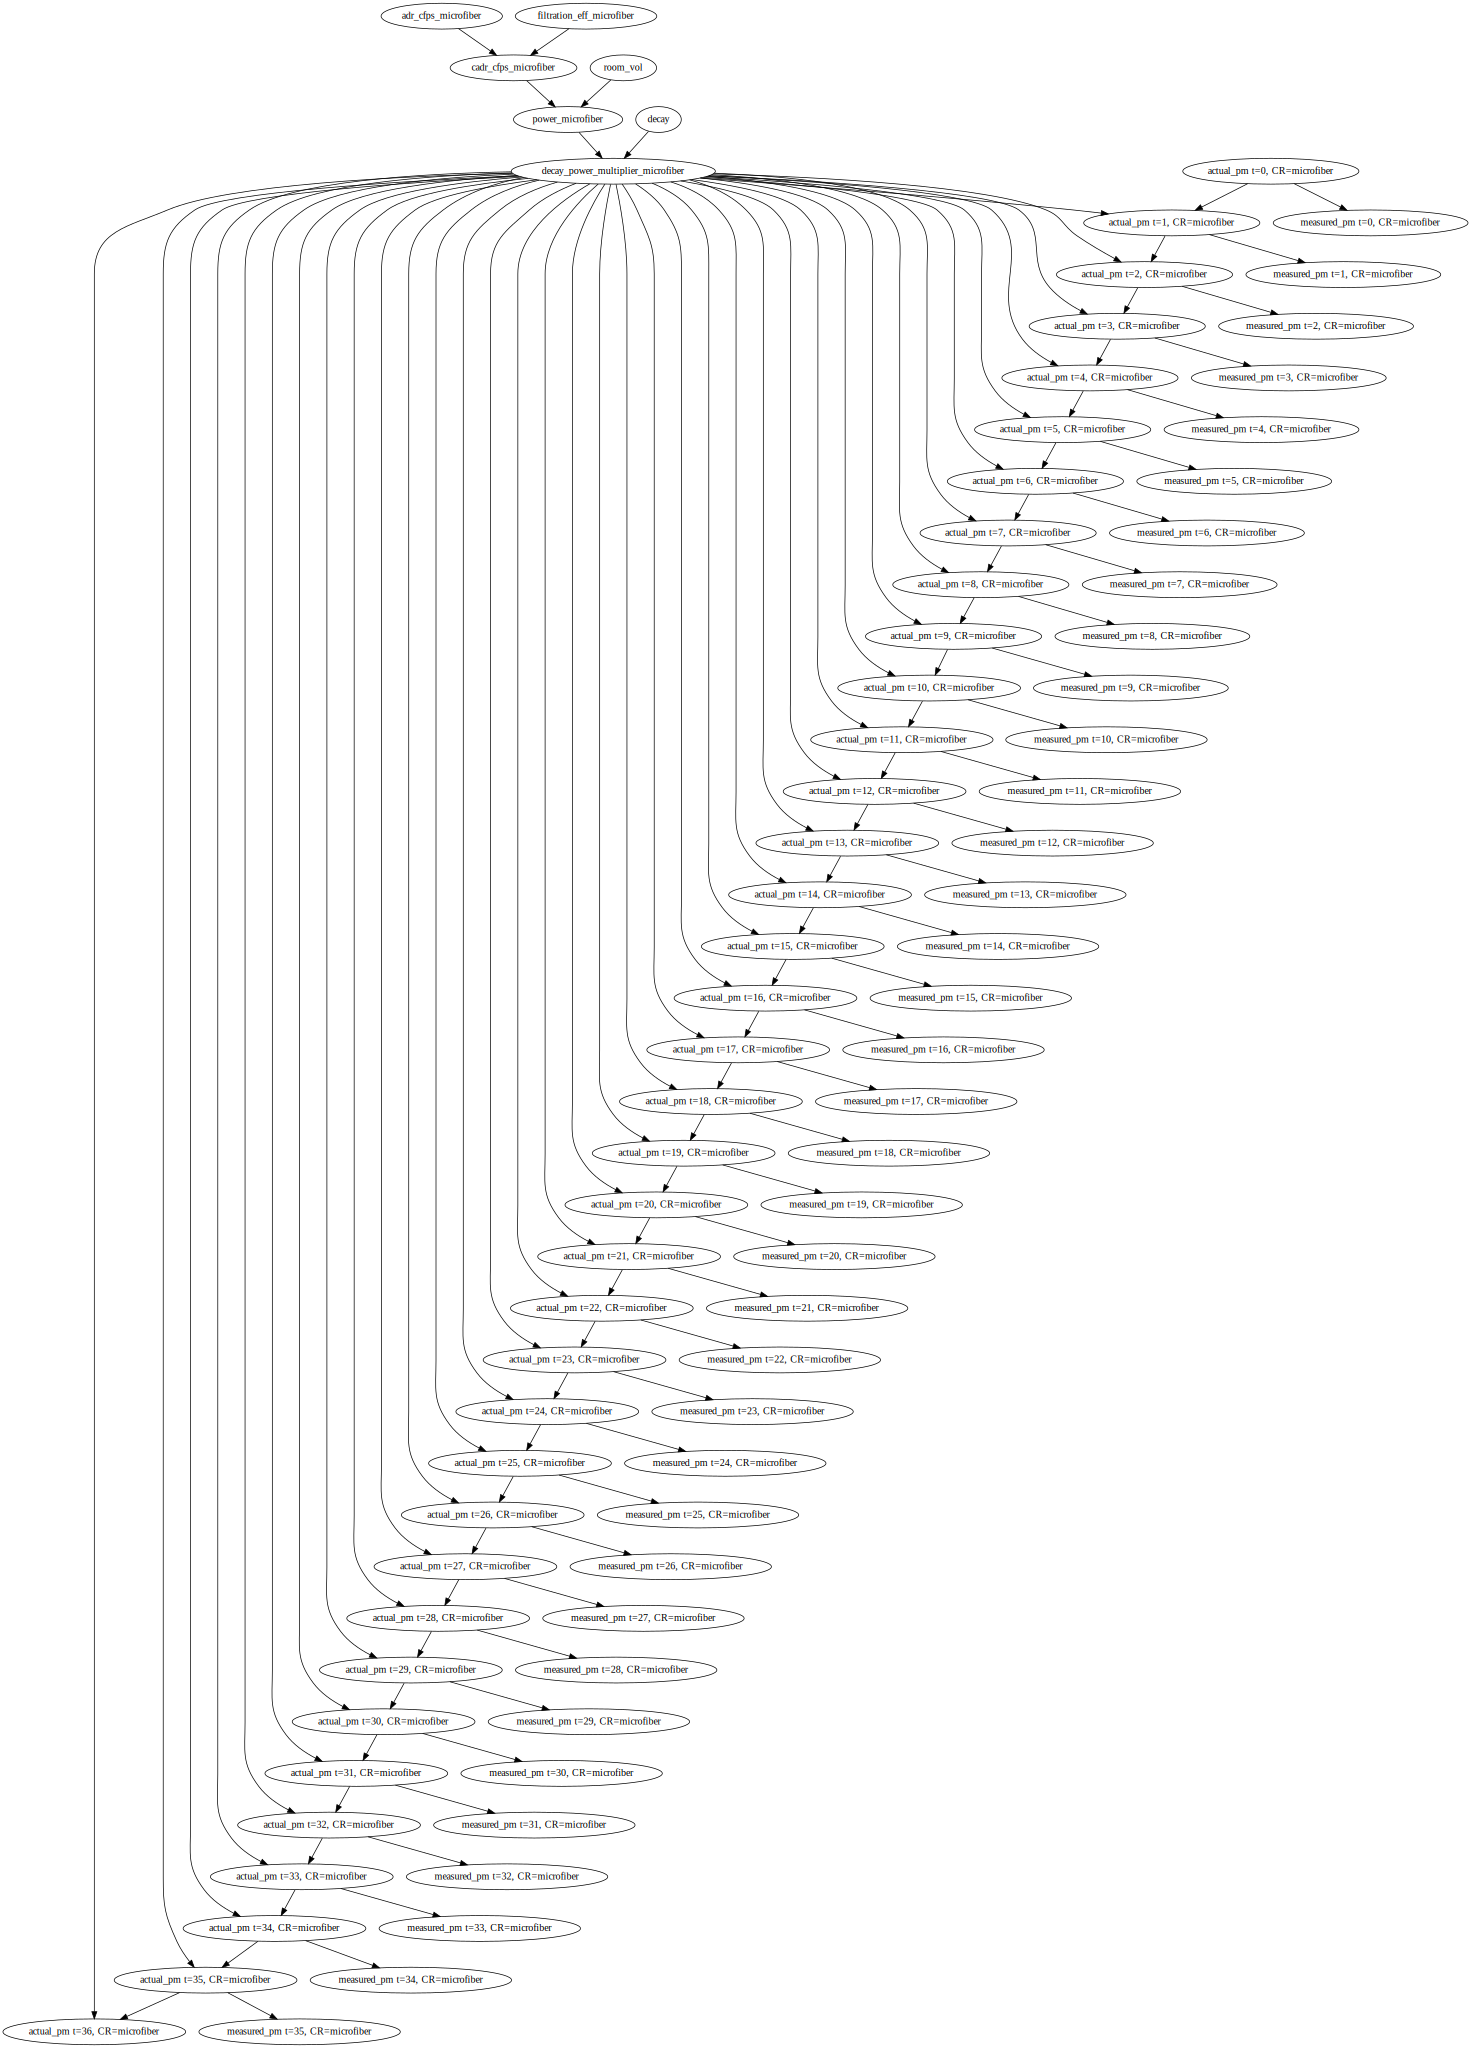

In [151]:
bn.graphviz_dag

In [152]:

result = VE(
    network=bn,
    query=Query(
        outcomes=["filtration_eff_microfiber"], 
        givens=[
            {
                'measured_pm t=1, CR=microfiber': 49
            },
            {
                'measured_pm t=0, CR=microfiber': 50
            },
            {
                'room_vol': 720
            },
            {
                'adr_cfps_microfiber': 3.8
            }
        ])
).compute()

denominator: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


In [153]:
get_df = result.get_df()

In [154]:
get_df

,filtration_eff_microfiber,room_vol,adr_cfps_microfiber,"measured_pm t=1, CR=microfiber","measured_pm t=0, CR=microfiber",value
0,0.10,720,3.8,49,50,0.014142
1,0.11,720,3.8,49,50,0.014142
2,0.12,720,3.8,49,50,0.014142
3,0.13,720,3.8,49,50,0.014142
4,0.14,720,3.8,49,50,0.014142
5,0.20,720,3.8,49,50,0.014142
6,0.21,720,3.8,49,50,0.014142
7,0.22,720,3.8,49,50,0.014142
8,0.23,720,3.8,49,50,0.014142
9,0.24,720,3.8,49,50,0.014142


<AxesSubplot:xlabel='filtration_eff_microfiber'>

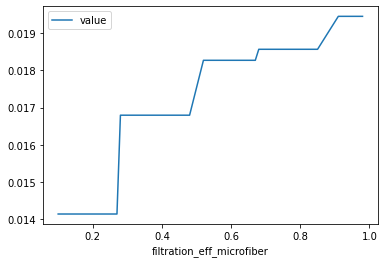

In [155]:
get_df[['filtration_eff_microfiber', 'value']].plot(x='filtration_eff_microfiber', y='value')

In [136]:
sns.heatmap(get_df.pivot_table(values=['value'], index=["power"], columns=['decay']))

KeyError: 'power'

In [112]:
actual_pm_df = generate_actual_pm_df()

KeyboardInterrupt: 

<AxesSubplot:ylabel='Density'>

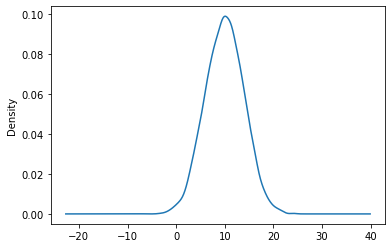

In [233]:
pd.Series(np.random.normal(10, 4, size=10000)).plot.kde()

In [ ]:
def measurement_df()